In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/housesalesprediction/kc_house_data.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures , StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn import metrics
from sklearn import ensemble
from sklearn.metrics import confusion_matrix,accuracy_score, mean_absolute_error
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D
import folium
from folium.plugins import HeatMap
import statsmodels.api as sm
import pickle
import xgboost
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
evaluation = pd.DataFrame({'Model': [],
                           'Root Mean Squared Error (RMSE)':[],
                           'Mean Absolute Error (MAE)':[],
                           'R-squared (train)':[],
                            'R-squared (test)':[],
                           'Adjusted R-squared (train)':[],
                            'Adjusted R-squared (test)':[],
                           'Explained Variance (train)':[],
                           'Explained Variance (test)':[],
                           '5-Fold Cross Validation':[]})
from time import time

In [3]:
import lightgbm 
import catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as ply
import plotly.graph_objs as go
from plotly import tools
from  plotly.offline import plot
# import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from matplotlib import colors
%matplotlib inline
from matplotlib.colors import Normalize


In [4]:
#Importing fundamental data exploration libaries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
sns.set()


In [5]:
house=pd.read_csv('../input/housesalesprediction/kc_house_data.csv')

In [6]:
house['price'] = (house['price']).astype(int)
house = house.set_index('id')

In [7]:
house['date'] = pd.to_datetime(house['date'])

In [8]:
# house["house_age"] = house["date"].dt.year - house['yr_built']
house['renovated'] = house['yr_renovated'].apply(lambda yr: 0 if yr == 0 else 1)

In [9]:
# Performing log transformation of numrical variable to get normal distribation.
house['price_log'] = np.log(house['price'])
house['sqft_living_log'] = np.log(house['sqft_living'])
house['sqft_lot_log'] = np.log(house['sqft_lot'])
house['sqft_above_log'] = np.log(house['sqft_above'])
house['sqft_living15_log'] = np.log(house['sqft_living15'])
house['sqft_lot15_log'] = np.log(house['sqft_lot15'])
house['sqft_basement_log'] = np.log1p(house['sqft_basement'])

In [10]:
zip_dummies = pd.get_dummies(house['zipcode'], prefix='zipcode')
house= pd.concat([house, zip_dummies], axis=1)

In [11]:
house.drop('zipcode', axis=1, inplace=True)

In [12]:
house['basement_present'] = house['sqft_basement'].apply(lambda x: 1 if x > 0 else 0) # Indicate whether there is a basement or not

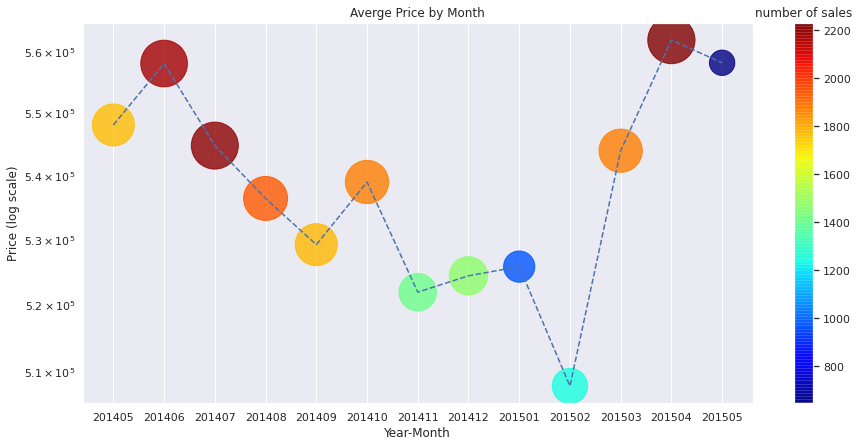

In [13]:
# monthly change of prices
house['ym'] = (house["date"].dt.year *100 + house["date"].dt.month).astype(str) 
ym_summary = house.groupby('ym')['price'].agg(['mean','count'])

vmin = np.min(ym_summary['count'])
vmax = np.max(ym_summary['count'])
norm = colors.Normalize(vmin,vmax)

plt.figure(figsize=(15,7))
plt.scatter(x=np.arange(ym_summary.shape[0]), y =ym_summary['mean'],c= ym_summary['count'],
            s= ym_summary['count'],norm=norm ,alpha = 0.8, cmap='jet')
plt.plot(np.arange(ym_summary.shape[0]), ym_summary['mean'] ,'--')
plt.xticks(np.arange(ym_summary.shape[0]),ym_summary.index.values)
plt.yscale('log')
plt.xlabel('Year-Month')
plt.ylabel('Price (log scale)')
clb = plt.colorbar() 
clb.ax.set_title('number of sales')
plt.title('Averge Price by Month')
plt.show()

In [14]:
 #convert bedrooms, floors to binary feature
house = pd.get_dummies(house,columns=['bedrooms','floors','ym'],drop_first=True)

In [15]:
house.drop('price', axis=1, inplace=True)
house.drop('sqft_living', axis=1, inplace=True)
house.drop('sqft_lot', axis=1, inplace=True)
house.drop('sqft_above', axis=1, inplace=True)
house.drop('sqft_living15', axis=1, inplace=True)
house.drop('sqft_lot15', axis=1, inplace=True)
house.drop('sqft_basement', axis=1, inplace=True)

In [16]:
# droping data columns because we do not need anymore.
house.drop('date', axis=1, inplace=True)

In [17]:
house.columns

Index(['bathrooms', 'waterfront', 'view', 'condition', 'grade', 'yr_built',
       'yr_renovated', 'lat', 'long', 'renovated',
       ...
       'ym_201408', 'ym_201409', 'ym_201410', 'ym_201411', 'ym_201412',
       'ym_201501', 'ym_201502', 'ym_201503', 'ym_201504', 'ym_201505'],
      dtype='object', length=117)

In [18]:
X = house.drop(['price_log'],axis=1)

In [19]:
y = house['price_log']

In [20]:
#training Testing 75 %training , 25% testing
#random_state=23
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=23)

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
seed = 123
pipelines = {
    'Scaled RFR' : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=seed)),
    'Scaled CAT' : make_pipeline(StandardScaler(), CatBoostRegressor(random_state=seed)),
    'Scaled LGBM' : make_pipeline(StandardScaler(), LGBMRegressor(random_state=seed)),
    'Scaled XGB':   make_pipeline(StandardScaler(), XGBRegressor(random_state=seed)),
    'Scaled GBM':   make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=seed))
}
scoring = 'r2'

In [27]:
rfr_hyper = {
'randomforestregressor__n_estimators' : [100],
'randomforestregressor__min_samples_split' : [10],
'randomforestregressor__min_samples_leaf' : [5],
'randomforestregressor__max_depth': [10]
}
cat_hyper = {
'catboostregressor__n_estimators' : [100],
'catboostregressor__learning_rate':[0.2],
'catboostregressor__l2_leaf_reg':[5],
'catboostregressor__border_count':[10],
'catboostregressor__max_depth': [10]
}
lgbm_hyper = {
'lgbmregressor__n_estimators' : [100],
'lgbmregressor__max_depth': [10],
'lgbmregressor__min_data_in_leaf':[128],
'lgbmregressor__num_leaves':[128],
'lgbmregressor__max_bin':[128],
'lgbmregressor__learning_rate':[0.2],
'lgbmregressor__bagging_fraction':[0.6]
}
xgb_hyper = {
'xgbregressor__n_estimators' : [100],
'xgbregressor__learning_rate': [0.20],
'xgbregressor__max_depth':[10],
'xgbregressor__subsample':[1],
'xgbregressor__min_child_weight': [3],
'xgbregressor__gamma': [0],
'xgbregressor__colsample_bytree': [0.3],
'xgbregressor__colsample_bylevel': [0.6],
'xgbregressor__reg_lambda':[1]
}
gbm_hyper = {
'gradientboostingregressor__n_estimators': [100],
'gradientboostingregressor__learning_rate' : [0.2],
'gradientboostingregressor__max_depth': [10],
'gradientboostingregressor__min_samples_split' : [5],
'gradientboostingregressor__min_samples_leaf' : [3],
'gradientboostingregressor__subsample':[0.8]
}
hyper={
    'Scaled RFR': rfr_hyper,
    'Scaled CAT': cat_hyper,
    'Scaled LGBM': lgbm_hyper,
    'Scaled XGB': xgb_hyper,
    'Scaled GBM':gbm_hyper
}

In [28]:
fitted_models={}

In [31]:
from sklearn.model_selection import GridSearchCV
for name , pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyper[name],cv=2,n_jobs=1,verbose=3,scoring=scoring)
    model.fit(X_train , y_train)
    fitted_models[name] = model
    print(name)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] randomforestregressor__max_depth=10, randomforestregressor__min_samples_leaf=5, randomforestregressor__min_samples_split=10, randomforestregressor__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestregressor__max_depth=10, randomforestregressor__min_samples_leaf=5, randomforestregressor__min_samples_split=10, randomforestregressor__n_estimators=100, score=0.871, total=   5.5s
[CV] randomforestregressor__max_depth=10, randomforestregressor__min_samples_leaf=5, randomforestregressor__min_samples_split=10, randomforestregressor__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV]  randomforestregressor__max_depth=10, randomforestregressor__min_samples_leaf=5, randomforestregressor__min_samples_split=10, randomforestregressor__n_estimators=100, score=0.865, total=   5.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.0s finished


Scaled RFR
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] catboostregressor__border_count=10, catboostregressor__l2_leaf_reg=5, catboostregressor__learning_rate=0.2, catboostregressor__max_depth=10, catboostregressor__n_estimators=100 
0:	learn: 0.4576373	total: 8.81ms	remaining: 872ms
1:	learn: 0.4042662	total: 18.2ms	remaining: 894ms
2:	learn: 0.3598288	total: 27.6ms	remaining: 893ms
3:	learn: 0.3245494	total: 35.9ms	remaining: 861ms
4:	learn: 0.2974977	total: 44ms	remaining: 835ms
5:	learn: 0.2736721	total: 52.1ms	remaining: 816ms
6:	learn: 0.2574900	total: 60.1ms	remaining: 798ms
7:	learn: 0.2432269	total: 68.1ms	remaining: 783ms
8:	learn: 0.2316725	total: 76.4ms	remaining: 772ms
9:	learn: 0.2241345	total: 84.4ms	remaining: 759ms
10:	learn: 0.2168704	total: 92.6ms	remaining: 749ms
11:	learn: 0.2128491	total: 96.5ms	remaining: 708ms
12:	learn: 0.2072949	total: 105ms	remaining: 702ms
13:	learn: 0.2037710	total: 114ms	remaining: 701ms
14:	learn: 0.1992957	total: 122ms

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


16:	learn: 0.1936789	total: 141ms	remaining: 691ms
17:	learn: 0.1914760	total: 150ms	remaining: 683ms
18:	learn: 0.1892665	total: 158ms	remaining: 674ms
19:	learn: 0.1876176	total: 166ms	remaining: 665ms
20:	learn: 0.1856315	total: 174ms	remaining: 655ms
21:	learn: 0.1843039	total: 182ms	remaining: 646ms
22:	learn: 0.1830980	total: 190ms	remaining: 637ms
23:	learn: 0.1819256	total: 198ms	remaining: 628ms
24:	learn: 0.1809046	total: 206ms	remaining: 619ms
25:	learn: 0.1796604	total: 215ms	remaining: 611ms
26:	learn: 0.1787393	total: 223ms	remaining: 602ms
27:	learn: 0.1776530	total: 231ms	remaining: 593ms
28:	learn: 0.1767693	total: 239ms	remaining: 584ms
29:	learn: 0.1759105	total: 247ms	remaining: 576ms
30:	learn: 0.1747827	total: 255ms	remaining: 568ms
31:	learn: 0.1736032	total: 264ms	remaining: 560ms
32:	learn: 0.1731104	total: 272ms	remaining: 552ms
33:	learn: 0.1720584	total: 280ms	remaining: 543ms
34:	learn: 0.1713189	total: 288ms	remaining: 535ms
35:	learn: 0.1706177	total: 296

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


1:	learn: 0.3991736	total: 19.2ms	remaining: 942ms
2:	learn: 0.3586610	total: 28.1ms	remaining: 909ms
3:	learn: 0.3239083	total: 36.3ms	remaining: 870ms
4:	learn: 0.2979181	total: 44.3ms	remaining: 842ms
5:	learn: 0.2749646	total: 53.1ms	remaining: 832ms
6:	learn: 0.2567217	total: 62.7ms	remaining: 833ms
7:	learn: 0.2416768	total: 72ms	remaining: 828ms
8:	learn: 0.2303499	total: 80.6ms	remaining: 815ms
9:	learn: 0.2217793	total: 89.2ms	remaining: 803ms
10:	learn: 0.2152715	total: 97.5ms	remaining: 789ms
11:	learn: 0.2094934	total: 106ms	remaining: 775ms
12:	learn: 0.2035022	total: 114ms	remaining: 762ms
13:	learn: 0.1998069	total: 122ms	remaining: 751ms
14:	learn: 0.1962982	total: 131ms	remaining: 742ms
15:	learn: 0.1934633	total: 141ms	remaining: 739ms
16:	learn: 0.1901787	total: 149ms	remaining: 730ms
17:	learn: 0.1883716	total: 158ms	remaining: 719ms
18:	learn: 0.1862352	total: 166ms	remaining: 707ms
19:	learn: 0.1842048	total: 174ms	remaining: 697ms
20:	learn: 0.1823503	total: 183m

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished


3:	learn: 0.3189334	total: 61.6ms	remaining: 1.48s
4:	learn: 0.2926652	total: 76.9ms	remaining: 1.46s
5:	learn: 0.2719806	total: 91.1ms	remaining: 1.43s
6:	learn: 0.2538934	total: 108ms	remaining: 1.44s
7:	learn: 0.2411517	total: 124ms	remaining: 1.42s
8:	learn: 0.2292463	total: 137ms	remaining: 1.39s
9:	learn: 0.2211130	total: 151ms	remaining: 1.36s
10:	learn: 0.2146986	total: 165ms	remaining: 1.34s
11:	learn: 0.2091914	total: 180ms	remaining: 1.32s
12:	learn: 0.2041680	total: 195ms	remaining: 1.3s
13:	learn: 0.2007986	total: 209ms	remaining: 1.28s
14:	learn: 0.1971415	total: 223ms	remaining: 1.26s
15:	learn: 0.1945689	total: 237ms	remaining: 1.24s
16:	learn: 0.1921754	total: 251ms	remaining: 1.22s
17:	learn: 0.1903230	total: 266ms	remaining: 1.21s
18:	learn: 0.1881619	total: 280ms	remaining: 1.19s
19:	learn: 0.1867331	total: 294ms	remaining: 1.18s
20:	learn: 0.1851146	total: 309ms	remaining: 1.16s
21:	learn: 0.1835814	total: 323ms	remaining: 1.15s
22:	learn: 0.1825314	total: 337ms	re

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  lgbmregressor__bagging_fraction=0.6, lgbmregressor__learning_rate=0.2, lgbmregressor__max_bin=128, lgbmregressor__max_depth=10, lgbmregressor__min_data_in_leaf=128, lgbmregressor__n_estimators=100, lgbmregressor__num_leaves=128, score=0.894, total=   0.4s
[CV] lgbmregressor__bagging_fraction=0.6, lgbmregressor__learning_rate=0.2, lgbmregressor__max_bin=128, lgbmregressor__max_depth=10, lgbmregressor__min_data_in_leaf=128, lgbmregressor__n_estimators=100, lgbmregressor__num_leaves=128 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  lgbmregressor__bagging_fraction=0.6, lgbmregressor__learning_rate=0.2, lgbmregressor__max_bin=128, lgbmregressor__max_depth=10, lgbmregressor__min_data_in_leaf=128, lgbmregressor__n_estimators=100, lgbmregressor__num_leaves=128, score=0.891, total=   0.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished


Scaled LGBM
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.3, xgbregressor__gamma=0, xgbregressor__learning_rate=0.2, xgbregressor__max_depth=10, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=100, xgbregressor__reg_lambda=1, xgbregressor__subsample=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.3, xgbregressor__gamma=0, xgbregressor__learning_rate=0.2, xgbregressor__max_depth=10, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=100, xgbregressor__reg_lambda=1, xgbregressor__subsample=1, score=0.892, total=   1.7s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.3, xgbregressor__gamma=0, xgbregressor__learning_rate=0.2, xgbregressor__max_depth=10, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=100, xgbregressor__reg_lambda=1, xgbregressor__subsample=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.3, xgbregressor__gamma=0, xgbregressor__learning_rate=0.2, xgbregressor__max_depth=10, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=100, xgbregressor__reg_lambda=1, xgbregressor__subsample=1, score=0.891, total=   1.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s finished


Scaled XGB
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] gradientboostingregressor__learning_rate=0.2, gradientboostingregressor__max_depth=10, gradientboostingregressor__min_samples_leaf=3, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=100, gradientboostingregressor__subsample=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gradientboostingregressor__learning_rate=0.2, gradientboostingregressor__max_depth=10, gradientboostingregressor__min_samples_leaf=3, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=100, gradientboostingregressor__subsample=0.8, score=0.886, total=   7.2s
[CV] gradientboostingregressor__learning_rate=0.2, gradientboostingregressor__max_depth=10, gradientboostingregressor__min_samples_leaf=3, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=100, gradientboostingregressor__subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV]  gradientboostingregressor__learning_rate=0.2, gradientboostingregressor__max_depth=10, gradientboostingregressor__min_samples_leaf=3, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=100, gradientboostingregressor__subsample=0.8, score=0.882, total=   7.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.8s finished


Scaled GBM


In [32]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

Scaled RFR 0.8681245963249117
Scaled CAT 0.8870347990665479
Scaled LGBM 0.892189088743327
Scaled XGB 0.8914887149436046
Scaled GBM 0.8837805621174353


Scaled RFR: 0.871974 (+/- 0.003271)
0:	learn: 0.4572682	total: 14.5ms	remaining: 1.43s
1:	learn: 0.3982110	total: 26.8ms	remaining: 1.31s
2:	learn: 0.3526979	total: 39.6ms	remaining: 1.28s
3:	learn: 0.3198915	total: 51.9ms	remaining: 1.24s
4:	learn: 0.2948244	total: 64.6ms	remaining: 1.23s
5:	learn: 0.2721957	total: 77.5ms	remaining: 1.21s
6:	learn: 0.2542354	total: 89.8ms	remaining: 1.19s
7:	learn: 0.2401449	total: 102ms	remaining: 1.18s
8:	learn: 0.2274745	total: 118ms	remaining: 1.2s
9:	learn: 0.2190113	total: 131ms	remaining: 1.18s
10:	learn: 0.2132201	total: 143ms	remaining: 1.16s
11:	learn: 0.2071365	total: 155ms	remaining: 1.14s
12:	learn: 0.2023898	total: 168ms	remaining: 1.12s
13:	learn: 0.1991275	total: 180ms	remaining: 1.11s
14:	learn: 0.1956658	total: 192ms	remaining: 1.09s
15:	learn: 0.1930021	total: 205ms	remaining: 1.07s
16:	learn: 0.1910297	total: 216ms	remaining: 1.06s
17:	learn: 0.1895807	total: 229ms	remaining: 1.04s
18:	learn: 0.1878357	total: 241ms	remaining: 1.03s

67:	learn: 0.1510721	total: 839ms	remaining: 395ms
68:	learn: 0.1507086	total: 851ms	remaining: 383ms
69:	learn: 0.1503255	total: 865ms	remaining: 371ms
70:	learn: 0.1499783	total: 879ms	remaining: 359ms
71:	learn: 0.1495232	total: 893ms	remaining: 347ms
72:	learn: 0.1492806	total: 908ms	remaining: 336ms
73:	learn: 0.1487996	total: 922ms	remaining: 324ms
74:	learn: 0.1483612	total: 936ms	remaining: 312ms
75:	learn: 0.1480250	total: 949ms	remaining: 300ms
76:	learn: 0.1477156	total: 962ms	remaining: 287ms
77:	learn: 0.1474400	total: 974ms	remaining: 275ms
78:	learn: 0.1471974	total: 986ms	remaining: 262ms
79:	learn: 0.1468662	total: 998ms	remaining: 250ms
80:	learn: 0.1465501	total: 1.01s	remaining: 237ms
81:	learn: 0.1462230	total: 1.02s	remaining: 225ms
82:	learn: 0.1459429	total: 1.03s	remaining: 212ms
83:	learn: 0.1454956	total: 1.05s	remaining: 200ms
84:	learn: 0.1451356	total: 1.06s	remaining: 188ms
85:	learn: 0.1448394	total: 1.07s	remaining: 175ms
86:	learn: 0.1444724	total: 1.0

33:	learn: 0.1686479	total: 427ms	remaining: 829ms
34:	learn: 0.1677878	total: 440ms	remaining: 816ms
35:	learn: 0.1672337	total: 452ms	remaining: 803ms
36:	learn: 0.1667025	total: 464ms	remaining: 790ms
37:	learn: 0.1655312	total: 476ms	remaining: 777ms
38:	learn: 0.1648723	total: 488ms	remaining: 764ms
39:	learn: 0.1644384	total: 501ms	remaining: 752ms
40:	learn: 0.1638806	total: 514ms	remaining: 740ms
41:	learn: 0.1633534	total: 526ms	remaining: 727ms
42:	learn: 0.1629122	total: 538ms	remaining: 714ms
43:	learn: 0.1624591	total: 551ms	remaining: 701ms
44:	learn: 0.1618825	total: 563ms	remaining: 688ms
45:	learn: 0.1614069	total: 575ms	remaining: 675ms
46:	learn: 0.1607038	total: 587ms	remaining: 662ms
47:	learn: 0.1600383	total: 600ms	remaining: 649ms
48:	learn: 0.1595466	total: 612ms	remaining: 637ms
49:	learn: 0.1591489	total: 624ms	remaining: 624ms
50:	learn: 0.1586709	total: 638ms	remaining: 613ms
51:	learn: 0.1580914	total: 650ms	remaining: 600ms
52:	learn: 0.1574653	total: 662

Scaled LGBM: 0.896735 (+/- 0.003099)
Scaled XGB: 0.897627 (+/- 0.003108)
Scaled GBM: 0.891933 (+/- 0.004111)


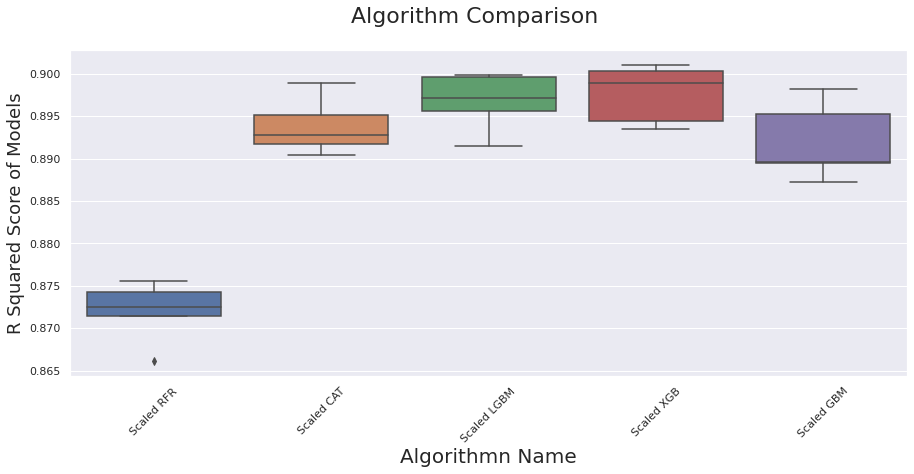

In [33]:
from sklearn.model_selection import KFold
results, names  = [], [] 
scoring = 'r2'
n_folds = 5
for name, model  in fitted_models.items():
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model.best_estimator_, X_train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn Name", fontsize=20)
ax.set_ylabel("R Squared Score of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()    

In [34]:
results

[array([0.87555748, 0.8724861 , 0.87144472, 0.86608146, 0.87429838]),
 array([0.89885823, 0.89171191, 0.89517403, 0.89036381, 0.89282815]),
 array([0.89964571, 0.89141765, 0.89985869, 0.89558095, 0.8971738 ]),
 array([0.90102004, 0.8934936 , 0.90035115, 0.89436488, 0.89890661]),
 array([0.89818792, 0.88956599, 0.89527388, 0.88720434, 0.88943509])]

In [35]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
for name , model in fitted_models.items():
    pred = model.predict(X_test)
    print( name )
    print( '------------' )
    print( 'R^2:', r2_score(y_test , pred ))
    print( 'MAE:', mean_absolute_error(y_test , pred))
    print()

Scaled RFR
------------
R^2: 0.8792047066371186
MAE: 0.13186381167388328

Scaled CAT
------------
R^2: 0.9004873015170389
MAE: 0.11979086409293425

Scaled LGBM
------------
R^2: 0.9070794291611534
MAE: 0.11454745694601756

Scaled XGB
------------
R^2: 0.9047660109599642
MAE: 0.11540646234809039

Scaled GBM
------------
R^2: 0.8957202052045892
MAE: 0.11973952732115026



In [36]:
fitted_models['Scaled RFR'].best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__min_samples_leaf': 5,
 'randomforestregressor__min_samples_split': 10,
 'randomforestregressor__n_estimators': 100}

In [38]:
fitted_models['Scaled CAT'].best_params_

{'catboostregressor__border_count': 10,
 'catboostregressor__l2_leaf_reg': 5,
 'catboostregressor__learning_rate': 0.2,
 'catboostregressor__max_depth': 10,
 'catboostregressor__n_estimators': 100}

In [39]:
fitted_models['Scaled LGBM'].best_params_

{'lgbmregressor__bagging_fraction': 0.6,
 'lgbmregressor__learning_rate': 0.2,
 'lgbmregressor__max_bin': 128,
 'lgbmregressor__max_depth': 10,
 'lgbmregressor__min_data_in_leaf': 128,
 'lgbmregressor__n_estimators': 100,
 'lgbmregressor__num_leaves': 128}

In [40]:
fitted_models['Scaled XGB'].best_params_

{'xgbregressor__colsample_bylevel': 0.6,
 'xgbregressor__colsample_bytree': 0.3,
 'xgbregressor__gamma': 0,
 'xgbregressor__learning_rate': 0.2,
 'xgbregressor__max_depth': 10,
 'xgbregressor__min_child_weight': 3,
 'xgbregressor__n_estimators': 100,
 'xgbregressor__reg_lambda': 1,
 'xgbregressor__subsample': 1}

In [41]:
fitted_models['Scaled GBM'].best_params_

{'gradientboostingregressor__learning_rate': 0.2,
 'gradientboostingregressor__max_depth': 10,
 'gradientboostingregressor__min_samples_leaf': 3,
 'gradientboostingregressor__min_samples_split': 5,
 'gradientboostingregressor__n_estimators': 100,
 'gradientboostingregressor__subsample': 0.8}

In [42]:
predictions = fitted_models['Scaled XGB'].predict(X_test)

In [43]:
ypred_train= fitted_models['Scaled XGB'].predict(X_train)

Text(0, 0.5, 'predicted price_log')

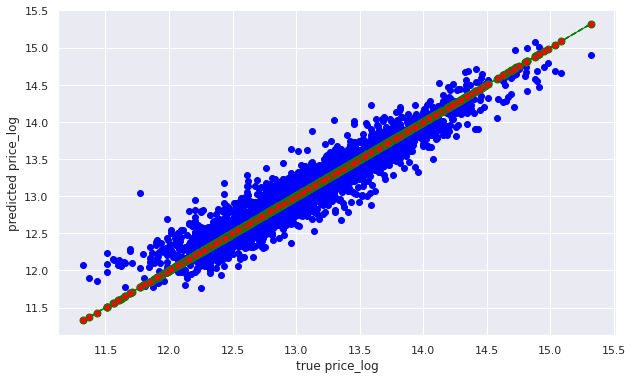

In [44]:
plt.figure(figsize=(10,6))
plt.scatter(y_test,predictions,color="blue",marker="o")
plt.plot(y_test,y_test,marker='o',
         color='green',markerfacecolor='red',
         markersize=7,linestyle='dashed')
plt.xlabel('true price_log')
plt.ylabel('predicted price_log')

In [58]:
diff = abs(y_test - predictions)

compare_actual = pd.DataFrame({'Test Data': y_test, 'Predicted Price' : predictions, 'Difference' : diff})
compare_actual = compare_actual.astype(float)
compare_actual.head(10)

,Test Data,Predicted Price,Difference
id,,,
2781270210,12.254387,12.220467,0.033920
2926049086,13.262125,13.335097,0.072972
6381501636,12.676076,12.806787,0.130710
6977000080,13.235692,13.311534,0.075842
4338800720,12.388394,12.615409,0.227015
3396820150,13.239257,13.399003,0.159746
8155500020,13.180632,13.233341,0.052709
3751600025,11.842229,12.047859,0.205630
2193330030,13.441689,13.321982,0.119707


In [62]:
actual_y_test = np.exp(y_test)
actual_predicted = np.exp(predictions)
diff = abs(actual_y_test - actual_predicted)

compare_actual = pd.DataFrame({'Test Data': actual_y_test, 'Predicted Price' : actual_predicted, 'Difference' : diff})
compare_actual = compare_actual.astype(int)
compare_actual.tail(10)

,Test Data,Predicted Price,Difference
id,,,
8562770430,567500,552626,14873
5694500105,595000,598267,3267
1446400715,279999,238642,41357
8677300720,616000,615878,121
7137970130,339999,316651,23347
7853220210,563500,609668,46168
2617370090,338500,435745,97245
8648100130,306500,307281,781
7702010030,551000,544181,6818


Text(0, 0.5, 'XG Boost prediction')

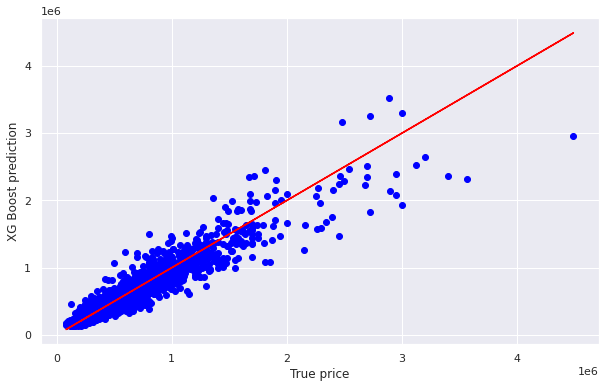

In [60]:
plt.figure(figsize=(10,6))
plt.scatter(actual_y_test,actual_predicted,color="blue",marker="o")
plt.plot(actual_y_test,actual_y_test,
         color='red',
         markersize=7)
plt.xlabel('True price')
plt.ylabel('XG Boost prediction')